<a href="https://colab.research.google.com/github/NikethnaSri-AI/Aanseaa_Technologies_Internship/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.5 MB/s eta 0:00:00


Import Libraries

In [3]:
import numpy as np
import pandas as pd
import re
import emoji
import tensorflow as tf
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [6]:
# Install once (Colab)
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Correct file path
file_path = "Tweets.csv"

# Load dataset
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "crowdflower/twitter-airline-sentiment",
    file_path
)
print(df.head())

Using Colab cache for faster access to the 'twitter-airline-sentiment' dataset.
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN   

In [7]:
print(df.shape)

(14640, 15)


In [10]:
confidence_threshold = 0.6
df = df.drop(df.query("airline_sentiment_confidence < @confidence_threshold").index, axis=0).reset_index(drop=True)

In [11]:
tweets_df = pd.concat([df['text'], df['airline_sentiment']], axis=1)
tweets_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica I didn't today... Must mean I n...,neutral
2,@VirginAmerica it's really aggressive to blast...,negative
3,@VirginAmerica and it's a really big bad thing...,negative
4,@VirginAmerica seriously would pay $30 a fligh...,negative
...,...,...
14397,@AmericanAir right on cue with the delays👌,negative
14398,@AmericanAir leaving over 20 minutes Late Flig...,negative
14399,@AmericanAir Please bring American Airlines to...,neutral
14400,"@AmericanAir you have my money, you change my ...",negative


In [12]:
tweets_df['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9113
neutral,2997
positive,2292


In [13]:
sentiment_ordering = ['negative', 'neutral', 'positive']
tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].apply(lambda x: sentiment_ordering.index(x))

In [14]:
tweets_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica I didn't today... Must mean I n...,1
2,@VirginAmerica it's really aggressive to blast...,0
3,@VirginAmerica and it's a really big bad thing...,0
4,@VirginAmerica seriously would pay $30 a fligh...,0
...,...,...
14397,@AmericanAir right on cue with the delays👌,0
14398,@AmericanAir leaving over 20 minutes Late Flig...,0
14399,@AmericanAir Please bring American Airlines to...,1
14400,"@AmericanAir you have my money, you change my ...",0


Text Preprocessing

In [23]:
ps = PorterStemmer()
def process_tweet(tweet):
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'@\w+', '', new_tweet) # Remove @s
    new_tweet = re.sub(r'#', '', new_tweet) # Remove hashtags
    new_tweet = re.sub(r':', ' ', emoji.demojize(new_tweet)) # Turn emojis into words
    new_tweet = re.sub(r'http\S+', '',new_tweet) # Remove URLs
    new_tweet = re.sub(r'\$\S+', 'dollar', new_tweet) # Change dollar amounts to dollar
    new_tweet = re.sub(r'[^a-z0-9\s]', '', new_tweet) # Remove punctuation
    new_tweet = re.sub(r'[0-9]+', 'number', new_tweet) # Change number values to number
    new_tweet = new_tweet.split(" ")
    new_tweet = list(map(lambda x: ps.stem(x), new_tweet)) # Stemming the words
    new_tweet = list(map(lambda x: x.strip(), new_tweet)) # Stripping whitespace from the words
    if '' in new_tweet:
        new_tweet.remove('')
    return new_tweet

In [28]:
vocabulary = set()
for tweet in tweets:
    for word in tweet:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)
print("Vocab length:", vocab_length)

Vocab length: 11250


In [29]:
max_seq_length = 0
for tweet in tweets:
    if len(tweet) > max_seq_length:
        max_seq_length = len(tweet)

print("Max sequence length:", max_seq_length)

Max sequence length: 90


In [33]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index
model_inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
model_inputs
model_inputs.shape

(14402, 90)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels, train_size=0.7, random_state=22)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


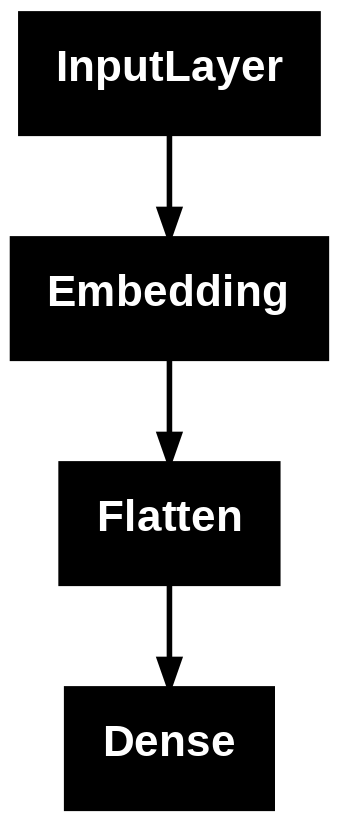

In [35]:
embedding_dim = 32
inputs = tf.keras.Input(shape=(max_seq_length,))
embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model)

Training Model

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:

batch_size = 32
epochs = 100
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6263 - loss: 0.8777 - val_accuracy: 0.7372 - val_loss: 0.6610 - learning_rate: 0.0010
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7745 - loss: 0.5542 - val_accuracy: 0.7923 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8704 - loss: 0.3836 - val_accuracy: 0.7938 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9079 - loss: 0.2834 - val_accuracy: 0.8012 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9382 - loss: 0.2097 - val_accuracy: 0.7967 - val_loss: 0.5159 - learning_rate: 0.0010
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9586 - loss: 0.1558 - val_accuracy: 0.7962 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9718 - loss: 0

Evaluating Model Performance

In [38]:
model.evaluate(X_test, y_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7938 - loss: 0.5122


[0.4945599138736725, 0.8009719848632812]

Evaluating Model with Sample Tweet

In [44]:
def evaluate_manual_tweet():
    while True:
        tweet = input("Enter a tweet (or type 'exit' to stop): ").strip()
        if tweet.lower() == 'exit':
            break

        processed = process_tweet(tweet)
        processed_text = " ".join(processed)
        seq = tokenizer.texts_to_sequences([processed_text])
        padded = pad_sequences(seq, maxlen=max_seq_length, padding='post')
        pred = model.predict(padded)
        label_idx = np.argmax(pred)

        print("\nPredicted sentiment:", sentiment_ordering[label_idx])
        print("Confidence:", round(pred[0][label_idx], 3), "\n")

evaluate_manual_tweet()

Enter a tweet (or type 'exit' to stop): the service was nice
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Predicted sentiment: positive
Confidence: 0.587 

Enter a tweet (or type 'exit' to stop): the airline is terrible
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted sentiment: negative
Confidence: 0.649 

Enter a tweet (or type 'exit' to stop): worst airline ever 😡
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicted sentiment: negative
Confidence: 0.945 

Enter a tweet (or type 'exit' to stop): service was ok
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Predicted sentiment: positive
Confidence: 0.453 

Enter a tweet (or type 'exit' to stop): The flight landed on time and everything went as planned
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Predicted sentiment: positive
Confidence: 0.467 

Enter a tweet (or type 'exit' to stop): the flight arrived at destination just in time 🙂
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicted sentiment: neutral
Confidence: 0.419 

Enter a tweet (or type 'exit' to stop): 